# Methodology

The aim of investigating the mean-squared displacements as a function of timestep is to fit a straight line and therefore obtain a estimate of the infinite timescale diffusion coefficient. 
This might seem like a straight forward concept, however, for a real simulation, with a limited number of atoms and simulation length, the observed value of the diffusion coefficient will vary upon repetition of a given simulation.
`kinisi` is a Python library that is capable of: 
<ol>
<li> Accurately estimating the infinite timescale diffusion coefficient from a single simulation</li>
<li> Quantifying the variance in the diffusion coefficient that would be observed on repetition of the simulation</li>
</ol>

In order to achieve this, it is neccessary to build up a complete picture of the observed diffusion from the simulation and use this information to apply the approach with the highest [statistical efficiency](https://en.wikipedia.org/wiki/Efficiency_(statistics)) to estimate the diffusion coefficient. 
The different approach that can be taken to estimate this are shown in the schematic below, which we will work through below. 

<center>
<img src="_static/schematic_kinisi.pdf" alt="A schematic showing the different possibilities for the analysis of diffusion processes by mean-squared displacement." width="750px"></img>
</center>
<center>
A schematic of the process of diffusion coefficient determination, where the process used in `kinisi` is identified with the pink box.
</center>

## Finding the mean-squared displacement

Consider first the displacements that we calculate from an atomic simulation. 
We have performed a simulation of lithium lanthanum zirconium oxide (LLZO) to use as an example, we will consider initially the displacements, $\mathbf{x}$, that occur in 5 ps of simulation time. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.optimize import minimize
from sklearn.utils import resample
from emcee import EnsembleSampler
from corner import corner

In [2]:
displacements = np.load('_static/displacements.npz')['disp']

print('Displacements shape', displacements.shape)

Displacements shape (192, 91, 3)


We can see that for this timestep, the `displacements` array has a shape of `(192, 6, 3)` this means that there are 192 atoms, each observed 6 times (i.e. in the whole simulation there 6 non-overlapping times that 2.1 ps of simulation is present), for 3 dimensions. 
Let us now visualise the probability distribution for the displacements. 

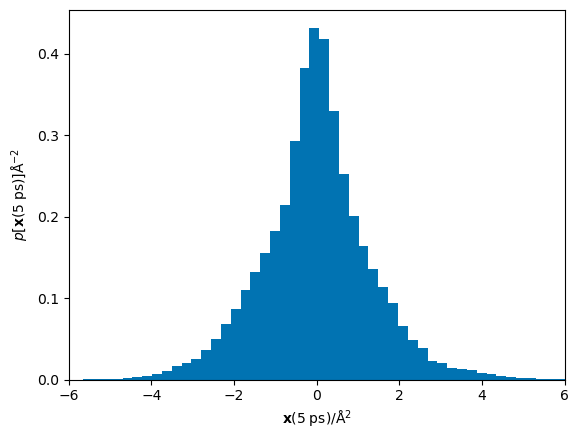

In [3]:
plt.hist(displacements.flatten(), bins=50, 
         density=True, color='#0173B2')
plt.xlabel('$\mathbf{x}(5\;\mathrm{ps})$/Å$^2$')
plt.ylabel('$p[\mathbf{x}(5\;\mathrm{ps})]$Å$^{-2}$')
plt.xlim(-6, 6)
plt.show()

The ordinate axis in the fitting of the Einstein equation is the mean of the squared displacements, $\mathbf{r}^2$, therefore we must square these displacements and determine the total displacement over all dimensions. 

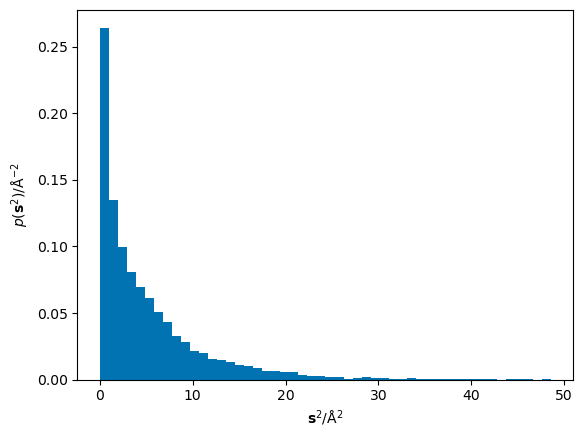

In [4]:
sq_displacements = np.sum(displacements ** 2, 
                          axis=2).flatten()

plt.hist(sq_displacements, bins=50, 
         density=True, color='#0173B2')
plt.xlabel('$\mathbf{s}^2$/Å$^2$')
plt.ylabel('$p(\mathbf{s}^2)$/Å$^{-2}$')
plt.show()

The mean of these squared displacements, $\langle\mathbf{r}^2\rangle$, can be found as the numerical mean.
Below, the mean is shown as a black vertical line over the histogram of the squared displacements. 

MSD = 5.111 Å$^2$


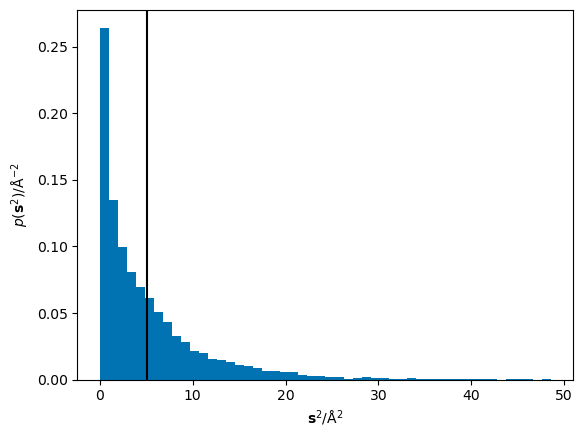

In [5]:
msd = np.mean(sq_displacements)

print(f'MSD = {msd:.3f} Å$^2$')

plt.hist(sq_displacements, bins=50, 
         density=True, color='#0173B2')
plt.axvline(msd, color='k')
plt.xlabel('$\mathbf{s}^2$/Å$^2$')
plt.ylabel('$p(\mathbf{s}^2)$/Å$^{-2}$')
plt.show()

Therefore, if we perform this operation at a series of different timesteps (the *x*-axis in the diffusion relation), we can populate the *y*-axis for our dataset. 
This is shown for the LLZO material below (note that throughout this description we focus on data in the diffusive regime alone). 

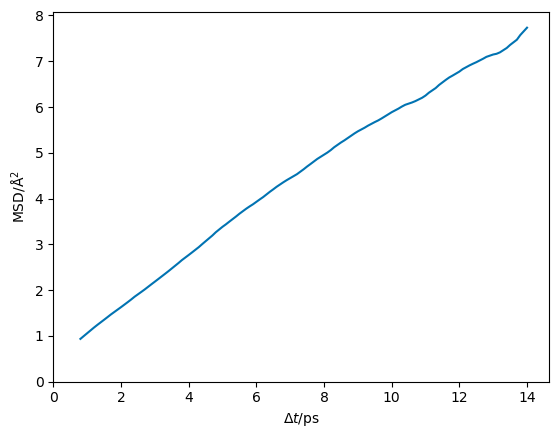

In [6]:
dt, msd = np.loadtxt('_static/msd.txt')

plt.plot(dt, msd, c='#0173B2')
plt.ylabel('MSD/Å$^2$')
plt.xlabel('$\Delta t$/ps')
plt.xlim(0, None)
plt.ylim(0, None)
plt.show()

The first thing we notice is that this data has no uncertainty associated with it. 
Given that this simulation is of a finite size, this is impossible. 
Consider, if we run another independent simulation of the same system, we will probably get different MSD plots. 

## Finding the uncertainty in the mean-squared displacement

It is possible to use [bootstrap mean resampling](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)) to determine the distribution of the mean-squared displacement. 
If the observed distribution is an accurate description of the true distribution, then bootstrap mean resampling is analogous to performing multiple observed of some subset of the true distribution. 
However, in order to accurately determine the distribution of mean-squared displacement, then we must resample using the number of non-overlapping trajectories. 
Hence, for 5 ps of simulation, there is only two non-overlapping trajectories per atom, so the number of samples in the resampling should be $2 \times N_{\mathrm{atoms}}$. 

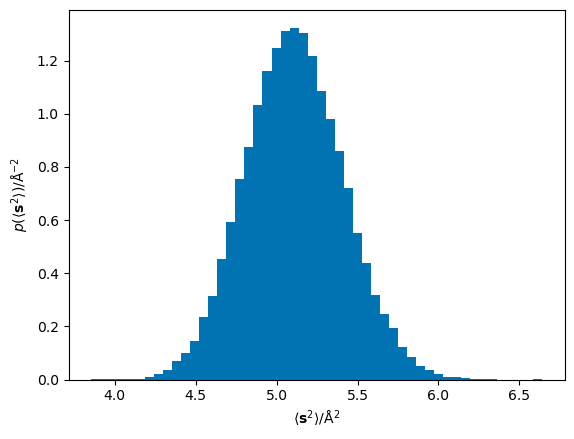

In [7]:
def mean_resample(samples: np.ndarray, n: int) -> np.ndarray:
    """
    Perform the bootstrap mean resampling for 10000 iterations.
    
    :param samples: Distribution to resample.
    :param n: Number of samples to draw each iteration. 
    :return: Distribution of mean. 
    """
    return np.array(
        [np.mean(resample(samples, n_samples=n)) for j in range(50000)])

resampled_msd = mean_resample(sq_displacements, 384)

plt.hist(resampled_msd, bins=50, density=True, color='#0173B2')
plt.xlabel(r'$\langle\mathbf{s}^2\rangle$/Å$^2$')
plt.ylabel(r'$p(\langle\mathbf{s}^2\rangle)$/Å$^{-2}$')
plt.show()

It is clear now that, from this bootstrap mean resampling, we have a distribution of mean-squared displacements (which are normally distributed). 
From this, we can find the mean and standard deviation. 

In [8]:
print(f'MSD = {resampled_msd.mean():.3f}+\-{resampled_msd.std():.3f}')

MSD = 5.111+\-0.300


The value of the MSD is very similar (within sampling error) to that determined as the numerical mean of the squared displacements. 
However, now we have information about the distribution of the mean-squared displacement and we can visualise this for a real material below. 

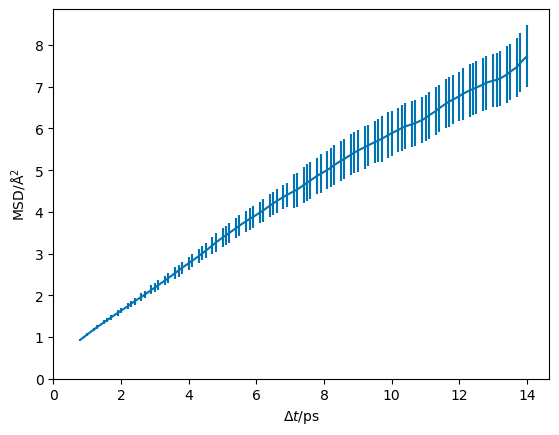

In [9]:
dt, msd, msd_std = np.loadtxt('_static/msd_std.txt')

plt.errorbar(dt, msd, msd_std, c='#0173B2')
plt.ylabel('MSD/Å$^2$')
plt.xlabel('$\Delta t$/ps')
plt.xlim(0, None)
plt.ylim(0, None)
plt.show()

## Understanding the correlation between measurements

However, the knowledge of the distribution of mean-squared displacements does not completely describe the variance in the data set.  


<div class="alert alert-info">
    
Thought experiment
    
Consider, a particle travelling on a one-dimensional random walk with a step size of 1 Å.
If, after 10 steps, the particle has been displaced by 5 Å then after 11 steps the particle could only be displaced by either 4 Å or 6 Å and after 12 steps the particle could only be displaced by 3, 4, 5, 6, 7 Å. 
</div>

This fact results in a substantial [correlation](https://en.wikipedia.org/wiki/Correlation) between the distributions of mean-squared displacement at different timesteps. 
To quantify this correlation, we have derived an approach to <a href='./_static/derivation.pdf'>estimate the full covariance matrix</a> (a description of the correlation between the timesteps). 
The result of this derivation is that the covariance between two timesteps, $\mathrm{cov}_i\Big(\big\langle \mathbf{r}^2(\Delta t_n) \big\rangle, \big\langle \mathbf{r}^2(\Delta t_{n+m}) \big\rangle\Big)$, is the product of the variance at the first timestep, $\Delta t_n$ and the ratio of maximum independent trajectories at each timestep,

$$
\mathrm{cov}\Big(\big\langle \mathbf{r}^2(\Delta t_n) \big\rangle, \big\langle \mathbf{r}^2(\Delta t_{n+m}) \big\rangle\Big) = \sigma^2\big(\langle \mathbf{r}^2(\Delta t_n) \rangle\big) \frac{N_i(\Delta t_{n})}{N_i(\Delta t_{n+m})},
$$

This approach is extremely computationally efficient, as there is no additional sampling required to determine this estimate of the full covariance matrix. 
However, the noise sampled variances may lead to poorly defined covariance matrices, therefore the variances are smoothed to follow the function defined in Equation 14 of the derivation. 
This leads to the covariance matrix shown for our LLZO simulation in the figure below. 

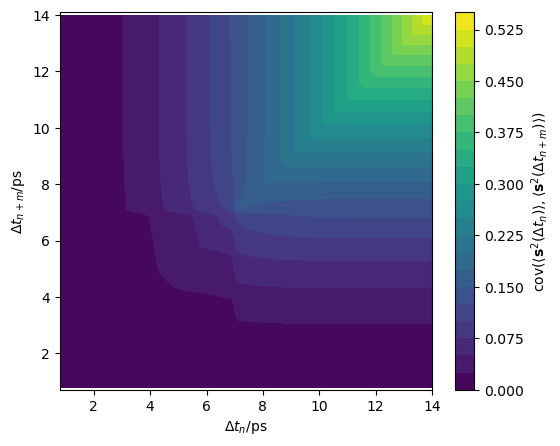

In [10]:
data = np.load('_static/cov.npz')
dt = data['dt']
cov = data['cov']

plt.subplots(figsize=(6, 4.9))
plt.contourf(*np.meshgrid(dt, dt), cov, levels=20)
plt.xlabel('$\Delta t_n$/ps')
plt.ylabel('$\Delta t_{n+m}$/ps')
plt.axis('equal')
plt.colorbar(label=r'$\mathrm{cov}' + 
             r'(\langle \mathbf{s}^2(\Delta t_n) \rangle, ' + 
             r'\langle \mathbf{s}^2(\Delta t_{n+m}) \rangle)$')
plt.show()

## Modelling a Gaussian process

The determination of the variance in the mean-squared displacement and estimation of the full covariance matrix allows the mean-squared displacement to be described as a covariant [Gaussian process](https://en.wikipedia.org/wiki/Gaussian_process), and therefore we can define it with a `scipy.stats.multivariate_normal` object. 

In [11]:
gp = multivariate_normal(mean=msd, cov=cov, allow_singular=True)

This object, in theory, allows us to simulate potential trajectories that could be observed in our simulation were repeated. 
In the plot below, we compare such a simulation from the Gaussian process produced from the full covariance matrix with that produced when there only the diagonal terms are defined (i.e. only the variances for each mean-squared displacement). 

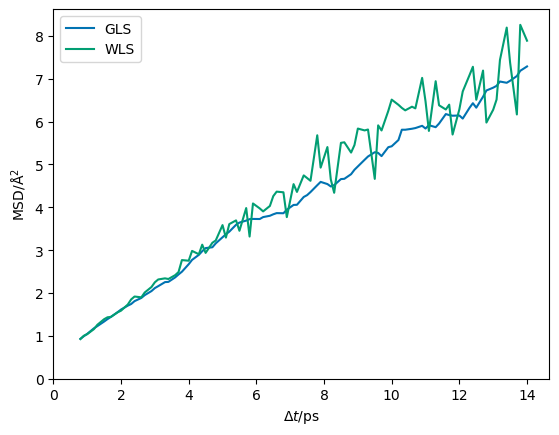

In [12]:
gp_wls = multivariate_normal(
    mean=msd, cov=np.diag(cov.diagonal()), allow_singular=True)

plt.plot(dt, gp.rvs(1).T, label='GLS', c='#0173B2')
plt.plot(dt, gp_wls.rvs(1).T, label='WLS', c='#029E73')
plt.legend()
plt.ylabel('MSD/Å$^2$')
plt.xlabel('$\Delta t$/ps')
plt.xlim(0, None)
plt.ylim(0, None)
plt.show()

The erratic changes in the mean-squared displacement that is observed in the plot with only the variances defined are unphysical when we consider the correlation thought experiment above. 

## Likelihood sampling a Gaussian process

As mentioned above, this process aims to determine the diffusion coefficient and ordinate offset, and their model variance, by fitting the Einstein relation. 
In `kinisi`, we use Markov chain Monte Carlo (MCMC) posterior sampling to perform this, using the [emcee package](https://emcee.readthedocs.io).
To perform this, we define a `log_posterior` function, that imposes a Bayesian prior probability that the diffusion coefficient must be positive. 

In [17]:
from scipy.linalg import pinvh

_, logdet = np.linalg.slogdet(cov)
logdet += np.log(2 * np.pi) * msd.size
inv = pinvh(cov)

def log_posterior(theta: np.ndarray) -> float:
    """
    Get the log likelihood for multivariate normal distribution.
    :param theta: Value of the gradient and intercept of the straight line.
    :return: Log-likelihood value.
    """
    if theta[0] < 0:
        return -np.inf
    model = dt * theta[0] + theta[1]
    diff = (model - msd)
    logl = -0.5 * (logdet + np.matmul(diff.T, np.matmul(inv, diff)))
    return logl

Then we can use a minimisation routine to determine maximum *a posteriori* values for the gradient and intercept. 

In [21]:
def nll(*args) -> float:
    """
    General purpose negative log-likelihood.

    :return: Negative log-likelihood
    """
    return -log_posterior(*args)

max_post = minimize(nll, [1, 0]).x

In [22]:
print(f'MAP: m = {max_post[0]:.3f}, c = {max_post[1]:.3f}')

MAP: m = 0.595, c = 0.462


After determining the maximum *a posteriori*, we can use `emcee` for sampling with 32 walkers for 1000 samples (with a 500 sample burn-in, which we discard in producing the `flatchain`). 

In [27]:
pos = max_post + max_post * 1e-3 * np.random.randn(32, max_post.size)

sampler = EnsembleSampler(*pos.shape, log_posterior)
sampler.run_mcmc(pos, 1000 + 500, progress=False)
flatchain = sampler.get_chain(flat=True, discard=500)

The diffusion coefficient (in units of cm<sup>2</sup>s<sup>-1</sup>) is found by dividing the gradient by 60000). 

In [28]:
flatchain[:, 0] /= 60000

We can then visualise these samples as a `corner` plot.

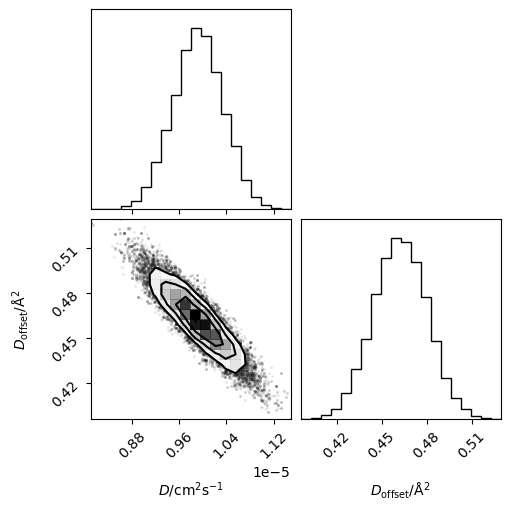

In [29]:
corner(flatchain, labels=['$D$/cm$^2$s$^{-1}$', '$D_{\mathrm{offset}}$/Å$^2$'])
plt.show()

It is also possible to visualise this as a traditional mean-squared displacement plot with credible intervals of the Einstein relation values. 

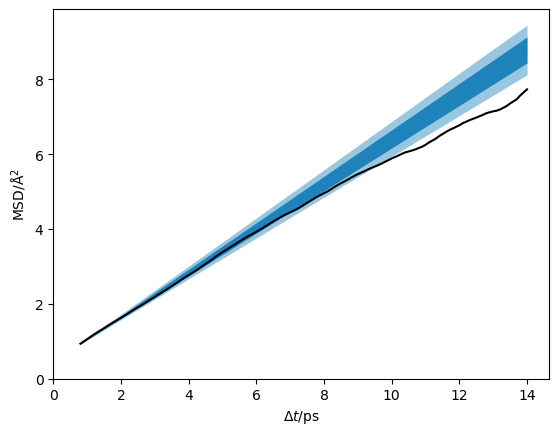

In [26]:
credible_intervals = [[16, 84], [2.5, 97.5]]
alpha = [0.8, 0.4]

plt.plot(dt, msd, color='#000000', zorder=10)
distribution = flatchain[
    :, 0] * 60000 * dt[:, np.newaxis] + flatchain[:, 1]
for i, ci in enumerate(credible_intervals):
    plt.fill_between(dt,
                     *np.percentile(distribution, ci, axis=1),
                     alpha=alpha[i],
                     color='#0173B2',
                     lw=0)
plt.ylabel('MSD/Å$^2$')
plt.xlabel('$\Delta t$/ps')
plt.xlim(0, None)
plt.ylim(0, None)
plt.show()